In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import njit
from scipy.stats import linregress

### Parámetros

In [2]:
deltas_seconds = []
deltas_seconds.append(1)
dt_seconds = 1.7
bins = 100
N_sim = 10000
T_steps  = 10000
t = np.arange(T_steps+1) * dt_seconds
max_quiet_len = 100000000

### Funciones

In [3]:
DT = 1.7  # tamaño ventana
rng = np.random.default_rng()

# Rachas y samplers empíricos
def run_lengths(binary_array, value=0):
    x = (binary_array == value).astype(int)
    if len(x) == 0:
        return np.array([], dtype=int)
    diff = np.diff(np.r_[0, x, 0])
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    return (ends - starts).astype(int)


def make_bootstrap_sampler(lengths, min_len=1):
    lengths = np.asarray(lengths, dtype=int)
    lengths = lengths[lengths >= min_len]
    if len(lengths) == 0:
        return lambda n=1: np.ones(n, dtype=int)
    def sampler(n=1):
        idx = rng.integers(0, len(lengths), size=n)
        return lengths[idx]
    return sampler

# Generación de secuencia on/off 
def synthesize_onoff_sequence(n_steps, quiet_sampler, active_sampler, start_state=1):
    seq = []
    state = start_state
    while len(seq) < n_steps:
        L = int(quiet_sampler(1)[0] if state == 0 else active_sampler(1)[0])
        L = max(L, 1)
        L = min(L, n_steps - len(seq))
        seq.extend([state]*L)
        state = 1 - state
    return np.array(seq, dtype=int)


# Simuladores
def brownian_free_with_pauses(n_steps, sigma_active, sigma_quiet=0.0, actividades=None, start=(0.0,0.0), jitter_quiet=False):
    start = np.asarray(start, float)
    traj = np.zeros((n_steps+1, 2), float)
    traj[0] = start
    if actividades is None:
        actividades = np.ones(n_steps, dtype=int)

    for t in range(n_steps): 
        if actividades[t] == 1:
            step = rng.normal(0, sigma_active, size=2)
        else:
            if jitter_quiet and sigma_quiet > 0:
                step = rng.normal(0, sigma_quiet, size=2)
            else:
                step = np.array([0.0, 0.0])
        traj[t+1] = traj[t] + step
    return traj


def build_empirical_samplers(csv_file, col_pred="pred_rf", quiet_label=0, max_quiet_len=None):
    df = pd.read_csv(csv_file)

    seq = (df[col_pred].values != quiet_label).astype(int)

    quiet_runs  = run_lengths(seq, value=0)
    active_runs = run_lengths(seq, value=1)

    # Filtrar rachas largas de quietud
    if max_quiet_len is not None:
        quiet_runs = [q for q in quiet_runs if q <= max_quiet_len]

    qsam = make_bootstrap_sampler(quiet_runs, min_len=1)
    asam = make_bootstrap_sampler(active_runs, min_len=1)
    return qsam, asam, seq

def fit_powerlaw_exponent(t, msd, tmin=None, tmax=None):
    mask = np.ones_like(t, dtype=bool)
    if tmin is not None:
        mask &= (t >= tmin)
    if tmax is not None:
        mask &= (t <= tmax)
    mask &= (t > 0) & (msd > 0)
    logt = np.log(t[mask])
    logmsd = np.log(msd[mask])
    slope, intercept, r, p, se = linregress(logt, logmsd)
    return slope, intercept, r

def msd_from_initial_single(positions):
    diffs = positions - positions[0]
    return np.sum(diffs**2, axis=1)  # (T,)}


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def step_lengths_by_lag(traj, lags_steps):
    traj = np.asarray(traj)
    assert traj.ndim == 2, "traj debe ser (T+1, d)"
    T_plus_1 = traj.shape[0]

    out = {}
    for k in sorted(set(int(l) for l in lags_steps if int(l) > 0)):
        # índices 0, k, 2k, 3k, ... tal que idx + k < T_plus_1
        idx = np.arange(0, T_plus_1 - k, k, dtype=int)
        if len(idx) == 0:
            out[k] = np.array([])
            continue
        dif = traj[idx + k] - traj[idx]       # (n_saltos, d)
        lengths = np.linalg.norm(dif, axis=1) # (n_saltos,)
        out[k] = lengths
    return out

def lags_seconds_to_steps(lags_seconds, dt_seconds):
    return [max(1, int(round(L / dt_seconds))) for L in lags_seconds]

def common_log_bins(lengths_dict, nbins=40, eps=1e-12):
    all_vals = np.concatenate([v for v in lengths_dict.values() if len(v) > 0])
    all_vals = all_vals[all_vals > 0]
    if len(all_vals) == 0:
        raise ValueError("Todas las longitudes son cero; no se pueden crear bins.")
    vmin = all_vals.min()
    vmax = all_vals.max()
    vmin = max(vmin, eps)
    edges = np.logspace(np.log10(vmin), np.log10(vmax), nbins+1)
    return edges

def hist_pdfs_by_lag(lengths_dict, bins):
    pdfs = {}
    centers = 0.5 * (bins[1:] + bins[:-1])
    widths  = np.diff(bins)
    for lag, vals in lengths_dict.items():
        hist, _ = np.histogram(vals, bins=bins, density=False)
        pdf = hist / (hist.sum() * widths + 1e-12)
        pdfs[lag] = (centers, pdf)
    return pdfs

def summarize_lengths(lengths_dict):
    summary = {}
    for lag, vals in lengths_dict.items():
        if len(vals) == 0:
            summary[lag] = {"n": 0, "mean": np.nan, "std": np.nan, "p50": np.nan, "p90": np.nan}
        else:
            summary[lag] = {
                "n":   int(len(vals)),
                "mean": float(np.mean(vals)),
                "std":  float(np.std(vals, ddof=1)),
                "p50":  float(np.percentile(vals, 50)),
                "p90":  float(np.percentile(vals, 90)),
            }
    return summary

In [5]:
def make_normal_sampler(mu, sigma, nonneg=True, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    def _sample(n=1):
        r = rng.normal(mu, sigma, size=n)
        if nonneg:
            r = np.clip(r, 0.0, None)
        return r
    return _sample

def make_uniform_sampler(r_min, r_max, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    def _sample(n=1):
        return rng.uniform(r_min, r_max, size=n)
    return _sample  

def make_powerlaw_sampler(alpha, Lmin=1.0, Lmax=None, rng=None):
    if alpha == 1:
        raise ValueError("Para alpha=1 se requiere un tratamiento especial (log-uniforme).")
    rng = np.random.default_rng() if rng is None else rng

    def _sample(n=1):
        u = rng.random(n)
        if Lmax is None:
            # Cola pura
            u = np.clip(u, 1e-12, 1-1e-12)
            return Lmin * (1 - u)**(-1.0/(alpha - 1.0))
        else:
            if Lmax <= Lmin:
                raise ValueError("Se requiere Lmax > Lmin.")
            a = 1.0 - alpha
            c0 = Lmin**a
            c1 = Lmax**a
            return (u*(c1 - c0) + c0)**(1.0/a)
    return _sample  # <-- función



# Random walk usando sampler
def random_walk_with_lengths(
    n_steps,
    length_sampler,
    actividades=None,
    start=(0.0, 0.0),
    jitter_quiet=False,
    sigma_quiet=0.0,
    rng=None
):
    rng = np.random.default_rng() if rng is None else rng
    start = np.asarray(start, float)

    traj = np.zeros((n_steps+1, 2), float)
    traj[0] = start

    if actividades is None:
        actividades = np.ones(n_steps, dtype=int)
    else:
        actividades = np.asarray(actividades, dtype=int)
        if len(actividades) != n_steps:
            raise ValueError("actividades debe tener largo n_steps.")

    # Direcciones aleatorias y longitudes
    theta = rng.uniform(0.0, 2*np.pi, size=n_steps)
    lengths = length_sampler(n_steps)  # <- ahora sí funciona

    for t in range(n_steps):
        if actividades[t] == 1:
            r = float(lengths[t])
            step = np.array([r*np.cos(theta[t]), r*np.sin(theta[t])], dtype=float)
        else:
            if jitter_quiet and sigma_quiet > 0:
                step = rng.normal(0.0, sigma_quiet, size=2)
            else:
                step = np.array([0.0, 0.0], dtype=float)
        traj[t+1] = traj[t] + step

    return traj


def brownian_with_distributed_steps(
    n_steps,
    dist="normal",
    dist_params=None,
    actividades=None,
    start=(0.0, 0.0),
    jitter_quiet=False,
    sigma_quiet=0.0,
    rng=None
):
    rng = np.random.default_rng() if rng is None else rng
    dist_params = {} if dist_params is None else dict(dist_params)

    if dist == "normal":
        mu = dist_params.get("mu", 0.0)
        sigma = dist_params.get("sigma", 1.0)
        nonneg = dist_params.get("nonneg", True)
        sampler = make_normal_sampler(mu, sigma, nonneg=nonneg, rng=rng)

    elif dist == "uniform":
        rmin = dist_params.get("r_min", 0.0)
        rmax = dist_params.get("r_max", 1.0)
        sampler = make_uniform_sampler(rmin, rmax, rng=rng)

    elif dist == "powerlaw":
        alpha = dist_params.get("alpha", 2.5)
        Lmin  = dist_params.get("Lmin", 1.0)
        Lmax  = dist_params.get("Lmax", None)
        sampler = make_powerlaw_sampler(alpha, Lmin=Lmin, Lmax=Lmax, rng=rng)

    else:
        raise ValueError("dist debe ser 'normal', 'uniform' o 'powerlaw'.")

    return random_walk_with_lengths(
        n_steps=n_steps,
        length_sampler=sampler,
        actividades=actividades,
        start=start,
        jitter_quiet=jitter_quiet,
        sigma_quiet=sigma_quiet,
        rng=rng
    )

### Simulaciones

In [6]:
# qsam, asam, _ = build_empirical_samplers("pred_T337.csv", col_pred="pred_rf", quiet_label=0, max_quiet_len=max_quiet_len)

alpha_quiet  = 1.44  # exponente para rachas de quietud
alpha_active = 1.57  # exponente para rachas de actividad
Lmin_quiet   = 1
Lmin_active  = 1
Lmax_quiet   = 58823
Lmax_active  = 5882

qsam = make_powerlaw_sampler(alpha_quiet,  Lmin=Lmin_quiet,  Lmax=Lmax_quiet,  rng=rng)
asam = make_powerlaw_sampler(alpha_active, Lmin=Lmin_active, Lmax=Lmax_active, rng=rng)

Pendiente estimada en ese rango: α ≈ -0.43


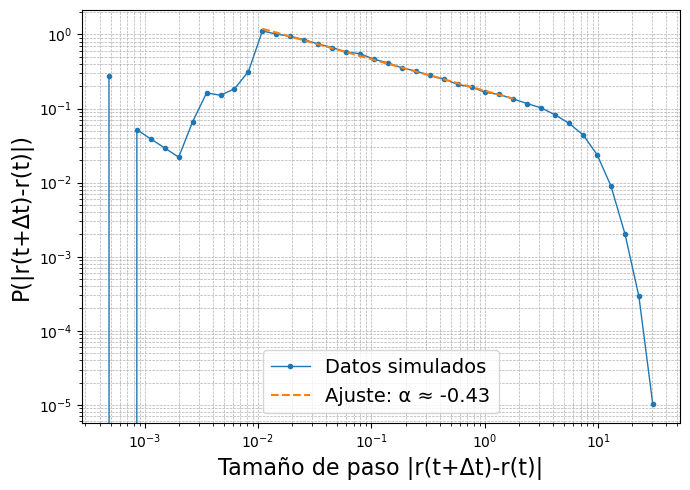

In [11]:
dt_seconds = 1.7
lags_steps = lags_seconds_to_steps([900], dt_seconds)

lengths_all = {int(k): [] for k in lags_steps if int(k) > 0}


msd_stack = []
lengths_all_sigma = {k: [] for k in lengths_all.keys()}

trajectories = []

for _ in range(N_sim):
    actividades = synthesize_onoff_sequence(T_steps, quiet_sampler=qsam, active_sampler=asam, start_state=1)
    #traj = brownian_with_distributed_steps(T_steps, dist="normal", dist_params=dict(mu=5, sigma=1, nonneg=True), actividades=actividades, jitter_quiet=False)
    #traj = brownian_with_distributed_steps(T_steps, dist="uniform", dist_params=dict(r_min=0, r_max=10), actividades=actividades,jitter_quiet=False)
    traj = brownian_with_distributed_steps(T_steps, dist="powerlaw", dist_params=dict(alpha=2, Lmin=0.01, Lmax=10), actividades=actividades, jitter_quiet=False)
    trajectories.append(traj)
    # msd_stack.append(msd_from_initial_single(traj))

    lengths_dict = step_lengths_by_lag(traj, lags_steps)
    for k, v in lengths_dict.items():
        lengths_all_sigma[k].append(v)

lengths_all_sigma = {k: np.concatenate(v) if len(v)>0 else np.array([])
                        for k, v in lengths_all_sigma.items()}


bins = common_log_bins(lengths_all_sigma, nbins=40)
pdfs = hist_pdfs_by_lag(lengths_all_sigma, bins)


lag = list(pdfs.keys())[0]
c, pdf = pdfs[lag]   # c = centros de bin, pdf = P(r)

# Rango de ajuste
r_min = 0.01   
r_max = 2

mask = (c > r_min) & (c < r_max) & (pdf > 0)

x = c[mask]
y = pdf[mask]

# Ajuste lineal en log10–log10
coef = np.polyfit(np.log10(x), np.log10(y), 1)
pendiente, intercepto = coef

print(f"Pendiente estimada en ese rango: α ≈ {pendiente:.2f}")

# Curva ajustada
y_fit = 10**(intercepto + pendiente * np.log10(x))

plt.figure(figsize=(7,5))
plt.loglog(c, pdf, 'o-', ms=3, lw=1, label="Datos simulados")
plt.loglog(x, y_fit, '--', label=f"Ajuste: α ≈ {pendiente:.2f}")
plt.xlabel("Tamaño de paso |r(t+Δt)-r(t)|", fontsize=16)
plt.ylabel("P(|r(t+Δt)-r(t)|)", fontsize=16)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### Mapa de calor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed: 10.7min finished


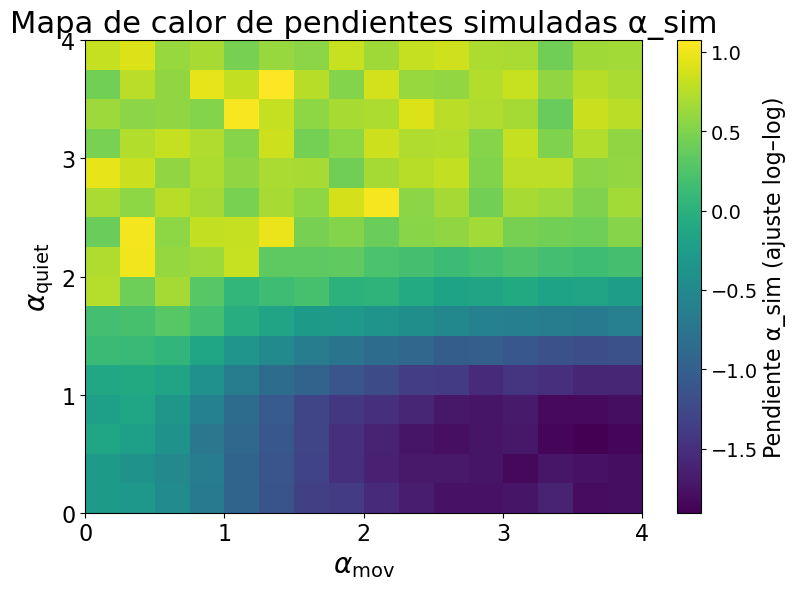

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed  # <--- NUEVO


# Calculo la pendiente α_sim
# Para un par dado (alpha_quiet, alpha_active)

def slope_for_params(alpha_q, alpha_a, N_sim=500):

    # Crear samplers de quietud y actividad
    qsam = make_powerlaw_sampler(alpha_q, Lmin=1, Lmax=58823, rng=rng)
    asam = make_powerlaw_sampler(alpha_a, Lmin=1, Lmax=588,   rng=rng)

    dt_seconds = 1.7
    lags_steps = lags_seconds_to_steps([900], dt_seconds)

    lengths_all_sigma = {int(k): [] for k in lags_steps}

    # Simulaciones
    for _ in range(N_sim):
        actividades = synthesize_onoff_sequence(
            T_steps,
            quiet_sampler=qsam,
            active_sampler=asam,
            start_state=1
        )

        traj = brownian_with_distributed_steps(
            T_steps,
            dist="powerlaw",
            dist_params=dict(alpha=2, Lmin=0.01, Lmax=10),
            actividades=actividades,
            jitter_quiet=False
        )

        lengths_dict = step_lengths_by_lag(traj, lags_steps)
        for k, v in lengths_dict.items():
            lengths_all_sigma[k].append(v)

    # Unificar arrays
    lengths_all_sigma = {
        k: np.concatenate(v) if len(v) > 0 else np.array([])
        for k, v in lengths_all_sigma.items()
    }

    # Crear bins y PDFs
    bins = common_log_bins(lengths_all_sigma, nbins=40)
    pdfs = hist_pdfs_by_lag(lengths_all_sigma, bins)

    # Extraer único lag (900 s)
    lag = list(pdfs.keys())[0]
    c, pdf = pdfs[lag]

    # Rango lineal para el ajuste
    r_min = 1e-2
    r_max = 2

    mask = (c > r_min) & (c < r_max) & (pdf > 0)
    x = c[mask]
    y = pdf[mask]

    # Si no hay puntos suficientes, devuelve NaN
    if len(x) < 5:
        return np.nan

    # Ajuste lineal log–log
    coef = np.polyfit(np.log10(x), np.log10(y), 1)
    slope, intercept = coef

    return slope


# ----------------------------------------
# Barrido de parámetros (paralelizado)
# ----------------------------------------

alpha_quiet_values  = np.linspace(0, 4, 16)
alpha_active_values = np.linspace(0, 4, 16)

heatmap = np.zeros((len(alpha_quiet_values), len(alpha_active_values)))


def compute_cell(i, aq, j, aa):
    """Función wrapper para usar con joblib."""
    val = slope_for_params(aq, aa, N_sim=300)
    return i, j, val


results = Parallel(n_jobs=-1, verbose=5)(
    delayed(compute_cell)(i, aq, j, aa)
    for i, aq in enumerate(alpha_quiet_values)
    for j, aa in enumerate(alpha_active_values)
)

# Rellenar el heatmap con los resultados
for i, j, val in results:
    heatmap[i, j] = val

# Dibujar mapa de calor
plt.figure(figsize=(8, 6))

plt.imshow(
    heatmap,
    origin="lower",
    cmap="viridis",
    extent=[
        alpha_active_values[0], alpha_active_values[-1],
        alpha_quiet_values[0], alpha_quiet_values[-1]
    ],
    aspect='auto'
)


plt.title("Mapa de calor de pendientes simuladas α_sim", fontsize=22)
plt.xlabel(r"$\alpha_{\text{mov}}$", fontsize=20)
plt.ylabel(r"$\alpha_{\text{quiet}}$", fontsize=20)


xticks = np.arange(
    int(np.floor(alpha_active_values[0])),
    int(np.ceil(alpha_active_values[-1])) + 1,
    1
)
yticks = np.arange(
    int(np.floor(alpha_quiet_values[0])),
    int(np.ceil(alpha_quiet_values[-1])) + 1,
    1
)

plt.xticks(xticks, xticks, fontsize=16)
plt.yticks(yticks, yticks, fontsize=16)

cbar = plt.colorbar()
cbar.set_label("Pendiente α_sim (ajuste log–log)", fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

